In [1]:
from datasets import load_dataset

from torch.utils.data import Dataset,DataLoader

from transformers import AutoProcessor,AutoModelForCausalLM,TrainingArguments,Trainer

from textwrap import wrap
from evaluate import load
import torch
import matplotlib.pyplot as plt
import numpy as np
from peft import get_peft_model
from peft import LoraConfig, TaskType

In [2]:
root='your data path'

In [3]:
ds = load_dataset(root)

Resolving data files:   0%|          | 0/5897 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/wangcheng/.cache/huggingface/datasets/imagefolder/total_resize-bd2ee9152da2ea68/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 5896
    })
})

In [5]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

In [6]:
def plot_images(images,captions):
    plt.figure(figsize=(20,20))
    for i in range(len(images)):
        ax = plt.subplot(1,len(images),i+1)
        caption = captions[i]
        caption = '\n'.join(wrap(caption,12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis('off')

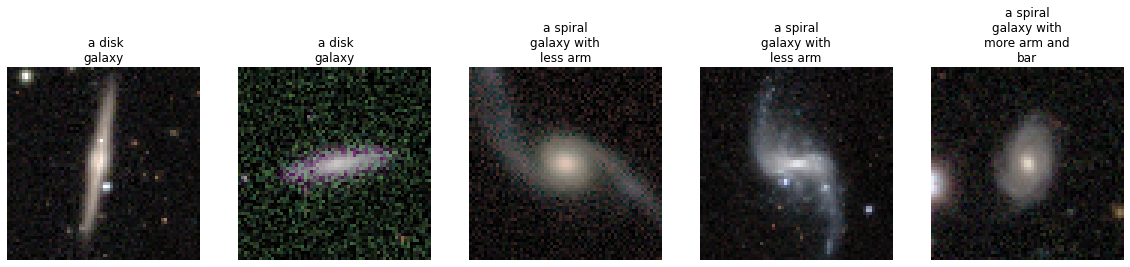

In [7]:
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [2]:
checkpoint ='microsoft/git-base'
processor = AutoProcessor.from_pretrained(checkpoint)

In [8]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [9]:
for item in train_ds

Dataset({
    features: ['image', 'text'],
    num_rows: 5306
})

In [3]:
model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [11]:
wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [12]:
model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [14]:
trainer.train()

/home/wangcheng/anaconda3/envs/yolov5/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/wangcheng/anaconda3/envs/yolov5/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

: 